In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ard.utils import distance_point_to_lineseg, smooth_max, distance_point_to_lineseg_nd

N_turbines = 6
D_rotor = 130.0

np.random.seed(0)
P_turbines = 20 * D_rotor * np.random.normal(size=(N_turbines, 2))
psi_platform = np.random.uniform(0.0, 2 * np.pi, N_turbines)


def get_platform_points(P_turbine_vec, psi_vec):
    P_moorings = []
    for point_turbine, psi_platform in zip(P_turbine_vec, psi_vec):
        L_mooring = 5 * D_rotor
        xP0 = point_turbine[0]
        yP0 = point_turbine[1]
        xP1 = point_turbine[0] + np.cos(psi_platform + np.pi) * L_mooring
        yP1 = point_turbine[1] + np.sin(psi_platform + np.pi) * L_mooring
        xP2 = point_turbine[0] + np.cos(psi_platform + 5 / 3 * np.pi) * L_mooring
        yP2 = point_turbine[1] + np.sin(psi_platform + 5 / 3 * np.pi) * L_mooring
        xP3 = point_turbine[0] + np.cos(psi_platform + 7 / 3 * np.pi) * L_mooring
        yP3 = point_turbine[1] + np.sin(psi_platform + 7 / 3 * np.pi) * L_mooring
        P_moorings.append(
            [
                [xP0, yP0],
                [xP1, yP1],
                [xP2, yP2],
                [xP3, yP3],
            ]
        )
    return np.array(P_moorings)


P_moorings = get_platform_points(P_turbines, psi_platform)

In [2]:


def distance_lineseg_to_lineseg(
    x_C, y_C, x_D, y_D, x_A, y_A, x_B, y_B, k_logistic=100.0, D_ref=1000.0
):
    dx_C = distance_point_to_lineseg_nd(
        np.array([x_C, y_C]), np.array([x_A, y_A]), np.array([x_B, y_B])
    )
    dx_D = distance_point_to_lineseg_nd(
        np.array([x_D, y_D]), np.array([x_A, y_A]), np.array([x_B, y_B])
    )

    alpha_smooth_max = -100 / D_ref
    distances = np.array([dx_C, dx_D])
    return smooth_max(distances, alpha_smooth_max)


def distance_point_to_mooring(x_C, y_C, P_mooring, D_ref=None):
    N_moorings = P_mooring.shape[0] - 1
    distance_moorings = []
    for i in range(1, N_moorings + 1):
        distance = distance_point_to_lineseg_nd(
                np.array([x_C, y_C]),
                np.array([P_mooring[0, 0], P_mooring[0, 1]]),
                np.array([P_mooring[i, 0], P_mooring[i, 1]])
            )
        distance_moorings.append(distance)
    if D_ref is None:
        return np.min(distance_moorings)
    else:
        alpha_smooth_max = -100 / D_ref
        return smooth_max(np.array(distance_moorings), alpha_smooth_max)


def distance_mooring_to_mooring(P_mooring_A, P_mooring_B, D_ref=None):
    N_moorings_A = P_mooring_A.shape[0] - 1
    N_moorings_B = P_mooring_B.shape[0] - 1

    distance_moorings = []

    x_D = P_mooring_A[0, 0]
    y_D = P_mooring_A[0, 1]
    for idx_mooring in range(1, N_moorings_A + 1):
        x_C = P_mooring_A[idx_mooring, 0]
        y_C = P_mooring_A[idx_mooring, 1]

        for i in range(1, N_moorings_B + 1):
            distance_moorings.append(
                distance_lineseg_to_lineseg(
                    x_C,
                    y_C,
                    x_D,
                    y_D,
                    P_mooring_B[0, 0],
                    P_mooring_B[0, 1],
                    P_mooring_B[i, 0],
                    P_mooring_B[i, 1],
                )
            )
    if D_ref is None:
        return np.min(distance_moorings)
    else:
        alpha_smooth_max = -100 / D_ref
        return smooth_max(np.array(distance_moorings), alpha_smooth_max)

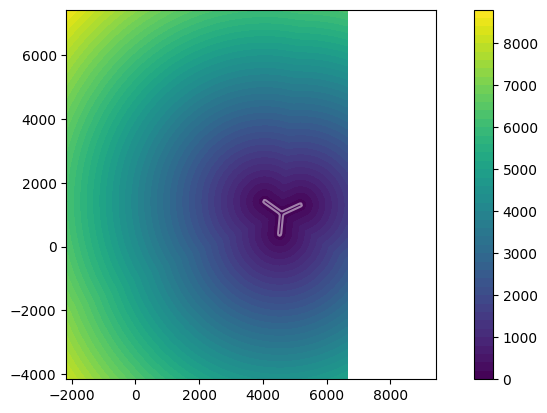

In [3]:
xA = -1.0
yA = 0.0
xB = 1.0
yB = 1.0

X, Y = np.meshgrid(
    # np.linspace(-3.0, 3.0, 201),
    # np.linspace(-3.0, 3.0, 201),
    np.linspace(
        np.min(P_moorings[:, :, 0]) - 1250.0, np.max(P_moorings[:, :, 0]) + 1250.0, 201
    ),
    np.linspace(
        np.min(P_moorings[:, :, 1]) - 1250.0, np.max(P_moorings[:, :, 1]) + 1250.0, 201
    ),
)
D = np.zeros_like(X)
D_pure = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(Y.shape[1]):
        # D[i,j] = distance_point_to_lineseg(X[i,j], Y[i,j], xA, yA, xB, yB)
        # D[i,j] = distance_point_to_mooring(X[i,j], Y[i,j], P_moorings[0,:,:], D_ref=None)
        D[i, j] = distance_point_to_mooring(
            X[i, j], Y[i, j], P_moorings[0, :, :], D_ref=1000.0
        )
        D_pure[i, j] = distance_point_to_mooring(
            X[i, j], Y[i, j], P_moorings[0, :, :], D_ref=None
        )
plt.contourf(X, Y, D, levels=51)
plt.colorbar()
plt.contour(X, Y, D, levels=[50.0], colors="w", alpha=0.5)
# plt.plot([xA, xB], [yA, yB], ".-k")
plt.axis("square");

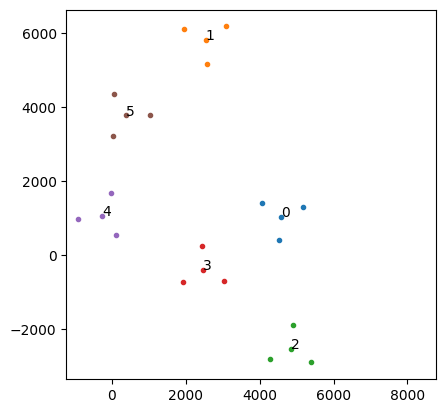

In [4]:
for i_turb in range(P_moorings.shape[0]):
    plt.text(P_turbines[i_turb, 0], P_turbines[i_turb, 1], i_turb)
    plt.plot(P_moorings[i_turb, :, 0], P_moorings[i_turb, :, 1], ".")
plt.axis("square");

In [5]:
for i in [
    2,
]:  # range(P_moorings.shape[0]):
    for j in range(P_moorings.shape[0]):
        if i == j:
            continue
        print(
            i,
            j,
            distance_mooring_to_mooring(
                P_moorings[i, :, :], P_moorings[j, :, :], D_ref=1000.0
            ),
        )

2 0 2317.9001793379816
2 1 7442.569505129606
2 3 2211.2296290842264
2 4 5341.776142039974
2 5 6872.083499436562


# Smooth Norm

In [48]:
from jax import grad 
from jax import numpy as jnp

def smooth_norm(vec: np.ndarray, buf=1E-6):
    return jnp.sqrt(buf**2 + jnp.sum(vec**2)) #- np.sqrt(buf**2)

smooth_norm_grad = grad(smooth_norm, [0])

def norm(vec: np.ndarray):
    return jnp.linalg.norm(vec)

norm_grad = grad(norm, [0])
    


In [57]:
base_vec = np.array([0, 0])
dif_vals = np.arange(0, 0.001, 1E-6)
result = np.zeros_like(dif_vals)
result_smooth = np.zeros_like(dif_vals)
result_grad = np.zeros_like(dif_vals)
result_smooth_grad = np.zeros_like(dif_vals)
for i, v in enumerate(dif_vals):
    result_smooth[i] = smooth_norm(np.array([v, 0.0]))
    result[i] = norm(np.array([v, 0.0]))
    result_smooth_grad[i] = smooth_norm_grad(jnp.array([v, 0.0]))[0][0]
    result_grad[i] = norm_grad(jnp.array([v, 0.0]))[0][0]

[None, Text(0, 0.5, 'Error')]

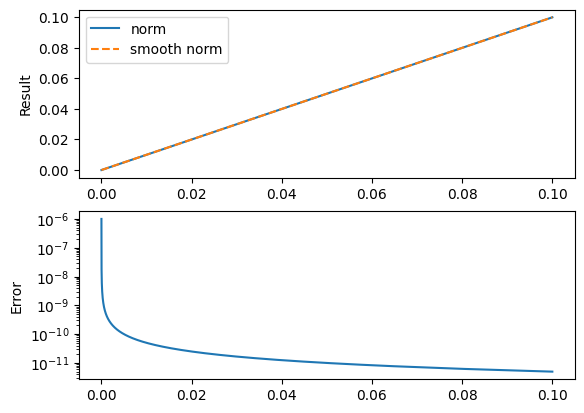

In [40]:

fig, ax = plt.subplots(3,1)
ax[0].plot(dif_vals, result, label="norm")
ax[0].plot(dif_vals, result_smooth, "--", label="smooth norm")
ax[0].set(ylabel="Result")
ax[0].legend()

ax[1].plot(dif_vals, result_grad, label="norm grad")
ax[1].plot(dif_vals, result_smooth_grad, label="smooth norm grad")
ax[1].set(ylabel="grad value")

ax[2].plot(dif_vals, result_smooth-result, label="error")
ax[2].set(yscale="log", ylabel="Error")
